In [49]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [50]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [51]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,transform_train=transform)


Files already downloaded and verified
Files already downloaded and verified


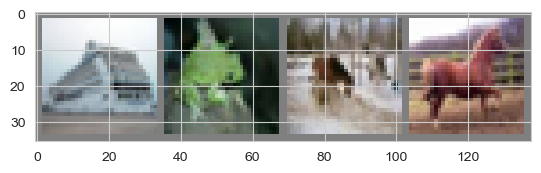

ship frog horse horse


In [52]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

In [53]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()       
        self.sub_model0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32)
        )
        self.sub_model1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        )
        self.model = nn.Sequential(
            nn.ReLU()
        )
        self.avg_ = nn.Sequential(
            nn.AvgPool2d(kernel_size=(8, 8))
        )
        self.res_model = nn.Sequential(
            nn.Linear(in_features=512, out_features=n_classes)
        )


    def forward(self, x):
        sub_model0 = self.sub_model0(x)
        sub_model1 = self.sub_model1(x)
        out = self.model(sub_model0 + sub_model1)

        out = self.avg_(out)

        out = out.reshape(x.shape[0], 512)
        out = self.res_model(out)
        return out


In [54]:
net = BasicBlockNet()
net

BasicBlockNet(
  (sub_model0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (sub_model1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (model): Sequential(
    (0): ReLU()
  )
  (avg_): Sequential(
    (0): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  )
  (res_model): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [55]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

In [56]:
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [57]:
net = net.to(device)

In [58]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        data = data.to(device)
        target = target.to(device)
        pred = model(data)
        loss = criterion(pred, target)
        loss_log.append(loss.item())
        pred = torch.max(pred,1)[-1]
        acc = (pred==target).sum() / target.shape[0]
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        
        data = data.to(device)
        target = target.to(device)
        pred = model(data)
        loss = criterion(pred,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        pred = torch.max(pred,1)[-1]
        acc = (pred==target).sum() / target.shape[0]
        
        acc_log.append(acc.item()) 
    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [23]:
optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4783804989819989, train acc: 0.47008438885102977
 val loss: 1.2734044531558422, val acc: 0.5477615248649679

Epoch 1
 train loss: 1.1774866910041795, train acc: 0.5860864455237903
 val loss: 1.131795000015421, val acc: 0.596875

Epoch 2
 train loss: 1.0746854350815307, train acc: 0.6238574040219378
 val loss: 1.0677490439820796, val acc: 0.6285239361702127

Epoch 3
 train loss: 1.0163015403956774, train acc: 0.6457993274850863
 val loss: 1.07792215271199, val acc: 0.6295877659574468

Epoch 4
 train loss: 0.9727822215291221, train acc: 0.6617140571639568
 val loss: 1.0725672945063165, val acc: 0.629033688027808

Epoch 5
 train loss: 0.9409686777012004, train acc: 0.6746906829926388
 val loss: 0.9676700734077616, val acc: 0.6621010638297873

Epoch 6
 train loss: 0.9141475828517726, train acc: 0.6841415839177817
 val loss: 0.9803380720158841, val acc: 0.660372340425532

Epoch 7
 train loss: 0.895742713969194, train acc: 0.6867450705611946
 val loss: 0.95162515006166

In [24]:
loss_, acc_ = test(net, test_loader)
print("test accuracy:", acc_)

test accuracy: 0.6951632165605095


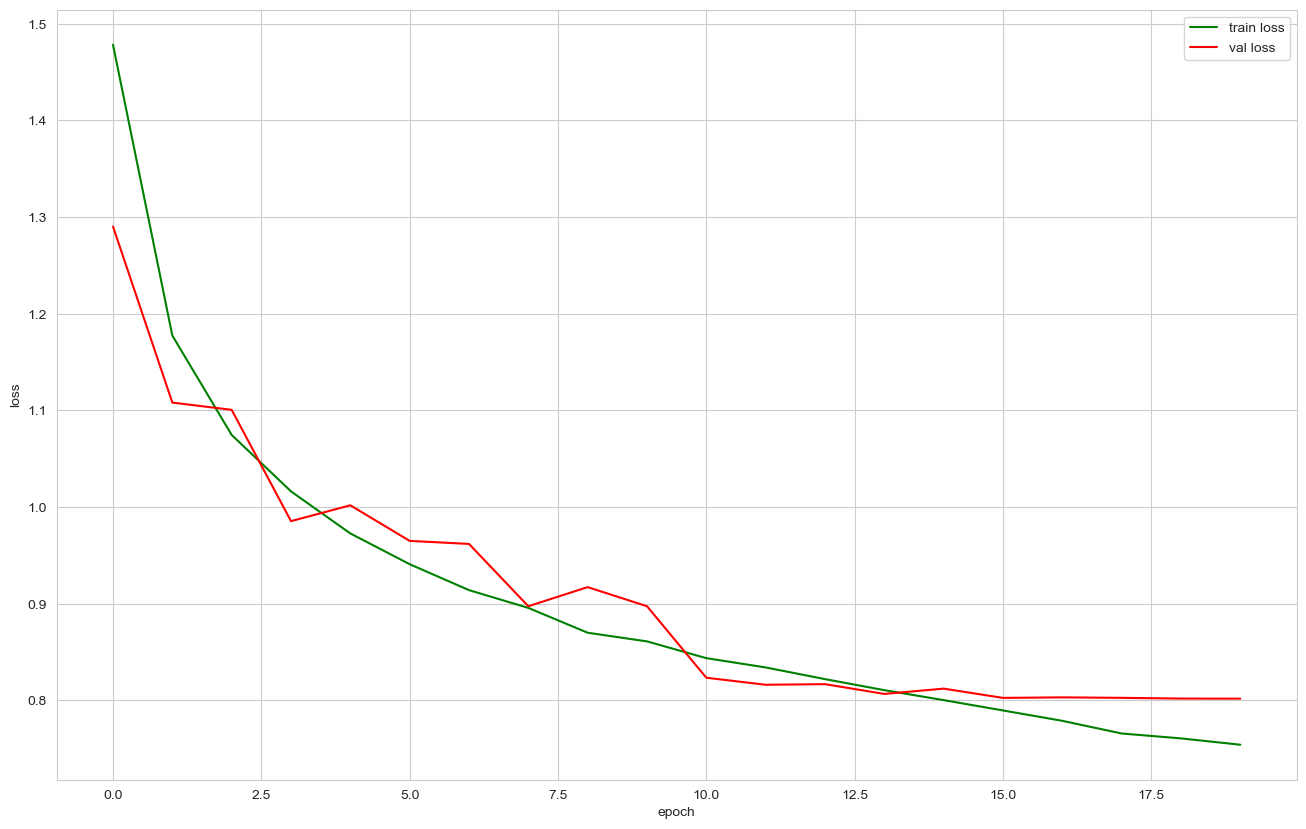

In [59]:
train_loss_log_mean = np.array(train_loss_log).reshape(20, -1)
train_acc_log_mean = np.array(train_acc_log).reshape(20, -1)
plt.figure(figsize=(16,10))
plt.plot((np.mean(train_loss_log_mean, axis=1)), label='train loss', color='green')
plt.plot(val_loss_log, label='val loss', color='red')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

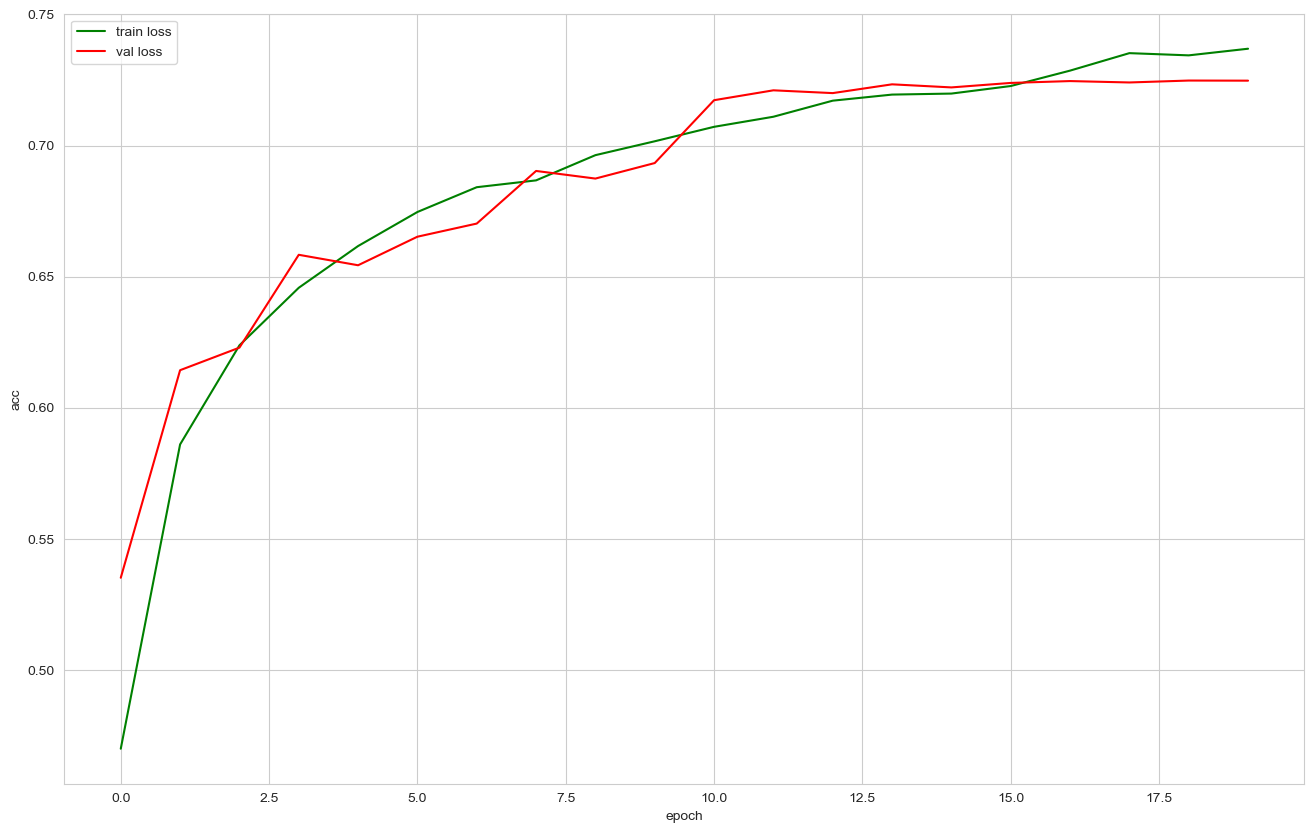

In [60]:
plt.figure(figsize=(16,10))
plt.plot((np.mean(train_acc_log_mean, axis=1)), label='train loss', color='green')
plt.plot(val_acc_log, label='val loss', color='red')

plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

plt.show()

In [30]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5293616984836362, train acc: 0.4528148667903879
 val loss: 1.3514208534930614, val acc: 0.5248448581137556

Epoch 1
 train loss: 1.2091723025607888, train acc: 0.5728690585009141
 val loss: 1.142910515754781, val acc: 0.6130097518575952

Epoch 2
 train loss: 1.0691478362466997, train acc: 0.6268199921961894
 val loss: 1.0728540004567897, val acc: 0.6294769502700643

Epoch 3
 train loss: 1.0081979585522054, train acc: 0.6465583377172132
 val loss: 1.053601482573976, val acc: 0.6410682624958931

Epoch 4
 train loss: 0.9666182902221052, train acc: 0.6637421650250172
 val loss: 1.030393820366961, val acc: 0.648027482184958

Epoch 5
 train loss: 0.9328029040226771, train acc: 0.6757924719092179
 val loss: 0.9690415402676197, val acc: 0.6679742906955962

Epoch 6
 train loss: 0.9104293943323208, train acc: 0.6839253068842007
 val loss: 0.9578375106162214, val acc: 0.6671985815180109

Epoch 7
 train loss: 0.8915561176087347, train acc: 0.690687026685509
 val loss: 0.9465

In [31]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8166692370252593, train acc: 0.36692429482392025
 val loss: 1.5794128717260159, val acc: 0.44488031914893617

Epoch 1
 train loss: 1.505926641075441, train acc: 0.4716799425359618
 val loss: 1.4272026021429833, val acc: 0.49122340425531913

Epoch 2
 train loss: 1.3930840265598332, train acc: 0.511907482386943
 val loss: 1.3430708590974199, val acc: 0.5273492908224147

Epoch 3
 train loss: 1.320922560622095, train acc: 0.5358693523424417
 val loss: 1.298148697995125, val acc: 0.5391622340425531

Epoch 4
 train loss: 1.2682403610436965, train acc: 0.554252905427211
 val loss: 1.2531823619883111, val acc: 0.5646941489361702

Epoch 5
 train loss: 1.2245335596353089, train acc: 0.5707185296733375
 val loss: 1.1883499700972375, val acc: 0.5868351063829788

Epoch 6
 train loss: 1.1875827126136864, train acc: 0.5846622812900508
 val loss: 1.1741693976077627, val acc: 0.5898049646235527

Epoch 7
 train loss: 1.1479920985711776, train acc: 0.5997486288848263
 val loss: 1.1

In [33]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5137656562071178, train acc: 0.456324268738574
 val loss: 1.2798958060589243, val acc: 0.5466312057160316

Epoch 1
 train loss: 1.1338534674435254, train acc: 0.6031152063357547
 val loss: 1.100811849502807, val acc: 0.6136746454746165

Epoch 2
 train loss: 1.0719641627951557, train acc: 0.6252162771425473
 val loss: 1.0812853838535066, val acc: 0.6220966311211281

Epoch 3
 train loss: 1.0647666334452097, train acc: 0.6280523635569613
 val loss: 1.0806493802273527, val acc: 0.6215647162275112

Epoch 4
 train loss: 1.063815479740582, train acc: 0.6293785909847978
 val loss: 1.0803154739927738, val acc: 0.6219636523977239

Epoch 5
 train loss: 1.0636649885822693, train acc: 0.6301294398482147
 val loss: 1.0803407998795205, val acc: 0.6222296098445325

Epoch 6
 train loss: 1.0636925150315113, train acc: 0.6282155915849605
 val loss: 1.0802891586689238, val acc: 0.6226285460147452

Epoch 7
 train loss: 1.0627984496095717, train acc: 0.6291296683674102
 val loss: 1.08

In [61]:
loss_, acc_ = test(net, test_loader)
print("test accuracy:", acc_)

test accuracy: 0.08937101910828026


In [35]:
net_lin = BasicBlockNet().to(device)
optimizer = optim.SGD(net_lin.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.LinearLR(optimizer)
tr_loss_log_lin, tr_acc_log_lin, val_loss_log_lin, val_acc_log_lin = train(net_lin, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4841971310226747, train acc: 0.46859085265635575
 val loss: 1.2495734902138407, val acc: 0.5591755319148937

Epoch 1
 train loss: 1.1922213253199074, train acc: 0.5782555824441927
 val loss: 1.0648147527207719, val acc: 0.6320257093044037

Epoch 2
 train loss: 1.0739768402450045, train acc: 0.627105641190705
 val loss: 1.0616380610364549, val acc: 0.6277925531914894

Epoch 3
 train loss: 1.0242099756514569, train acc: 0.6421022134027707
 val loss: 1.0116732490823623, val acc: 0.6505097518575952

Epoch 4
 train loss: 0.9925063731901389, train acc: 0.6552012600890026
 val loss: 1.0227514381104328, val acc: 0.6423758864402771

Epoch 5
 train loss: 0.9597760467250342, train acc: 0.6663293288220435
 val loss: 0.969339745856346, val acc: 0.6632092199427017

Epoch 6
 train loss: 0.9255964642686861, train acc: 0.6782408918933415
 val loss: 0.9486447816199445, val acc: 0.6699911348363187

Epoch 7
 train loss: 0.90012514286111, train acc: 0.6889649712407393
 val loss: 0.98

In [37]:
loss_exp, acc_exp = test(net_lin, test_loader)
print("test accuracy", acc_exp)

test accuracy 0.6964570063694268


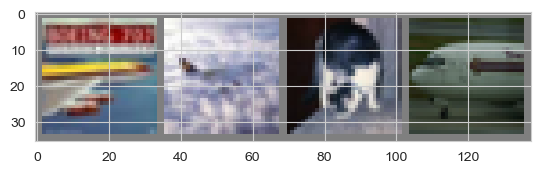

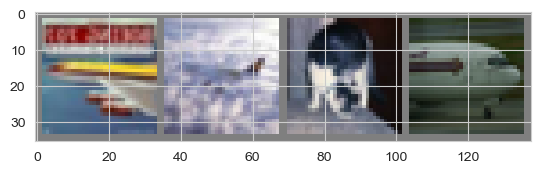

In [62]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

In [63]:

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4941304898131265, train acc: 0.4632573779365916
 val loss: 1.288435126872773, val acc: 0.5517730497299357

Epoch 1
 train loss: 1.1680111611565027, train acc: 0.5905711347921675
 val loss: 1.1326949971787472, val acc: 0.6022606382978724

Epoch 2
 train loss: 1.0639298690084567, train acc: 0.6303375555130856
 val loss: 1.0540584850818553, val acc: 0.6315602837724889

Epoch 3
 train loss: 1.0091527641582314, train acc: 0.6484966701955638
 val loss: 1.0198448980108221, val acc: 0.6476728723404256

Epoch 4
 train loss: 0.9654197541407736, train acc: 0.6661905850091407
 val loss: 0.9961204779909012, val acc: 0.6482269502700644

Epoch 5
 train loss: 0.929544330732914, train acc: 0.6763760120602805
 val loss: 0.9456844570788931, val acc: 0.6723625885679366

Epoch 6
 train loss: 0.9098450057685267, train acc: 0.6845986223090066
 val loss: 0.9328726299265597, val acc: 0.6779033688788718

Epoch 7
 train loss: 0.8926188047886766, train acc: 0.6903116021993173
 val loss: 0.9

In [44]:
loss_st, acc_st = test(net, test_loader)
print("test accuracy:", acc_st)

test accuracy: 0.7253184713375797


In [64]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 3)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net_gaussian = BasicBlockNet().to(device)
optimizer = optim.SGD(net_gaussian.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log_gaussian, tr_acc_log_gaussian, val_loss_log_gaussian, val_acc_log_gaussian = train(net_gaussian, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5536651552486245, train acc: 0.4453063789189843
 val loss: 1.3942532387185604, val acc: 0.49851507087971303

Epoch 1
 train loss: 1.2950437188802297, train acc: 0.5446265343120372
 val loss: 1.2027767100232714, val acc: 0.573470744680851

Epoch 2
 train loss: 1.1871076024646514, train acc: 0.5861354138995002
 val loss: 1.1609476294923335, val acc: 0.6018173758019792

Epoch 3
 train loss: 1.1271530509648855, train acc: 0.6055187385740403
 val loss: 1.1094639818719092, val acc: 0.6114804965384463

Epoch 4
 train loss: 1.0847142610079192, train acc: 0.6206050861688157
 val loss: 1.1276405499336568, val acc: 0.6053856382978723

Epoch 5
 train loss: 1.0561372269442137, train acc: 0.6276606163333496
 val loss: 1.0824110634783481, val acc: 0.6192375885679366

Epoch 6
 train loss: 1.0364371617707735, train acc: 0.6393518215777452
 val loss: 1.0467308508588913, val acc: 0.6346187944107867

Epoch 7

In [65]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 3)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net_gaussian = BasicBlockNet().to(device)
optimizer = optim.SGD(net_gaussian.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log_gaussian, tr_acc_log_gaussian, val_loss_log_gaussian, val_acc_log_gaussian = train(net_gaussian, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5536651552486245, train acc: 0.4453063789189843
 val loss: 1.3942532387185604, val acc: 0.49851507087971303

Epoch 1
 train loss: 1.2950437188802297, train acc: 0.5446265343120372
 val loss: 1.2027767100232714, val acc: 0.573470744680851

Epoch 2
 train loss: 1.1871076024646514, train acc: 0.5861354138995002
 val loss: 1.1609476294923335, val acc: 0.6018173758019792

Epoch 3
 train loss: 1.1271530509648855, train acc: 0.6055187385740403
 val loss: 1.1094639818719092, val acc: 0.6114804965384463

Epoch 4
 train loss: 1.0847142610079192, train acc: 0.6206050861688157
 val loss: 1.1276405499336568, val acc: 0.6053856382978723

Epoch 5
 train loss: 1.0561372269442137, train acc: 0.6276606163333496
 val loss: 1.0824110634783481, val acc: 0.6192375885679366

Epoch 6
 train loss: 1.0364371617707735, train acc: 0.6393518215777452
 val loss: 1.0467308508588913, val acc: 0.6346187944107867

Epoch 7